In [55]:
import matplotlib.pyplot as plt

from mtcnn import caffe_pb2 as pb
import cv2
import numpy as np

In [56]:
class Module:
    def __init__(self, name):
        self.name = name

    def forward(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        x = self.forward(*args, **kwargs)
        return x


class ParaMater:
    def __init__(self, value):
        self.value = value
        self.delta = np.zeros(self.value.shape)


class ModuleList(Module):
    def __init__(self, *args):
        super(ModuleList, self).__init__('ModuleList')
        self.modules_list = list(args)

    def modules(self):
        return self.modules_list

    def forward(self, x):
        for module in self.modules_list:
            x = module(x)
        return x

In [57]:
class Initialize:
    def __init__(self, name):
        self.name = name

    def apply(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        self.apply(*args, **kwargs)


class GaussianInitializer(Initialize):
    def __init__(self, mu, sigma):
        super(GaussianInitializer, self).__init__('GaussianInitializer')
        self.mu = mu
        self.sigma = sigma

    def apply(self, value):
        value[...] = np.random.normal(self.mu, self.sigma, value.shape)

In [58]:
class Conv2d(Module):
    def __init__(self, kernel_size, num_output, channel, stride=1, padding=0):
        super(Conv2d, self).__init__('Conv2d')
        # 先创建参数
        self.kernel_size = kernel_size
        self.num_output = num_output
        self.stride = stride
        self.padding = padding
        self.channel = channel

        # 初始化kernel和bias
        # kernel维度为：(filter_num, channel, kernel_size, kernel_size)
        self.kernel = ParaMater(np.ones((self.num_output, self.channel,
                                         self.kernel_size, self.kernel_size)))
        # bias维度为：(filter_num, )
        self.bias = ParaMater(np.zeros(self.num_output))

        # 对kernel进行初始化
        initer = GaussianInitializer(0, np.sqrt(2 / channel))  # np.sqrt(2 / input_feature)
        initer.apply(self.kernel.value)

    # 层数为
    def forward(self, x):
        # 1、保存输入图片的维度
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        # 2、计算输出图片的维度
        self.oh = (ih + self.padding * 2 - self.kernel_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.kernel_size) // self.stride + 1
        # 3、计算im2col转换之后的矩阵维度
        col_w = self.oh * self.ow
        col_h = self.kernel_size * self.kernel_size * self.channel
        self.column = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.num_output, self.oh, self.ow))
        khalf = self.kernel_size // 2
        self.kcol = self.kernel.value.reshape(self.num_output, -1)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.column[b, column_y, column_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.column[b]).reshape(self.num_output, self.oh,
                                                                  self.ow) + self.bias.value.reshape(self.num_output,
                                                                                                     1, 1)
        return self.output


class PRelu(Module):
    def __init__(self, feature_num, inplace=False):
        super(PRelu, self).__init__('PRelu')
        self.feature_num = feature_num
        self.inplace = inplace
        self.alpha = ParaMater(np.zeros(feature_num))

    def forward(self, x):
        if not self.inplace:  # 默认不修改原数据，而是复制一份进行激活
            x = x.copy()

        # 进行激活
        for channel in range(x.shape[1]):  # 一个通道一个通道进行激活
            negative = x[:, channel] < 0  # 大于0的不变，小于0的修改
            x[:, channel][negative] = x[:, channel][negative] * self.alpha.value[channel]
        return x


class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        # 步长为2， kernel_size为2的池化核，会使输入图片长宽减半，面积减小为原来的1/4
        super(MaxPooling2d, self).__init__('MaxPooling2d')
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.kernel_size) / self.stride) + 1), int(
            np.ceil((iw - self.kernel_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]

                        for kx in range(self.kernel_size):
                            for ky in range(self.kernel_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output


class Softmax(Module):
    def __init__(self):
        super(Softmax, self).__init__('Softmax')

    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx

In [59]:
# 把caffemodel里的参数填充到Conv层里
def fill_conv(module, weight):
    kernel = module.kernel.value  # 10 * 3 * 3 * 3
    bias = module.bias.value  # 10 * 1
    kernel[...] = np.array(weight.blobs[0].data).reshape(kernel.shape)
    bias[...] = np.array(weight.blobs[1].data).reshape(bias.shape)


# 把caffemodel里的参数填充到PRelu层里
def fill_p_relu(module, weight):
    alpha = module.alpha.value
    alpha[...] = np.array(weight.blobs[0].data).reshape(alpha.shape)


class PNet(Module):  # 全卷积网络(FCN)
    def __init__(self):
        super(PNet, self).__init__('PNet')
        self.backbone = ModuleList(  # 搭建主干网络
            Conv2d(3, 10, 3),
            PRelu(10),
            MaxPooling2d(),
            Conv2d(3, 16, 10),
            PRelu(16),
            Conv2d(3, 32, 16),
            PRelu(32),
        )
        # 支线confidence和bbox
        self.confidence = Conv2d(1, 2, 32)
        self.bbox = Conv2d(1, 4, 32)

        self.softmax = Softmax()

    def forward(self, x):
        x = self.backbone(x)
        return self.softmax(self.confidence(x)), self.bbox(x)

    def load(self, path):  # 加载caffe_model
        net = pb.NetParameter()
        with open(path, 'rb') as f:
            net.ParseFromString(f.read())

        # 把caffemodule中的参数读出来存到字典中
        layer_map = {layer.name: layer for layer in net.layer}
        # print(layer_map.keys())
        para_layer_name = ['conv1', 'PReLU1', 'pool1', 'conv2', 'PReLU2', 'conv3', 'PReLU3']  # 有参数的层的名字

        # 读出来参数赋值给PRelu层和Conv层
        for module_name, module in zip(para_layer_name, self.backbone.modules()):
            if isinstance(module, Conv2d):
                fill_conv(module, layer_map[module_name])
            if isinstance(module, PRelu):
                fill_p_relu(module, layer_map[module_name])

        # 再给支线层赋值
        fill_conv(self.confidence, layer_map['conv4-1'])
        fill_conv(self.bbox, layer_map['conv4-2'])



In [60]:
class BBox:
    def __init__(self, x, y, r, b, score=0):
        self.x, self.y, self.r, self.b, self.score = x, y, r, b, score
        self.landmarks = []

    def __xor__(self, other):
        '''
        计算box和other的IoU
        '''
        cross = self & other
        union = self | other
        return cross / (union + 1e-6)

    def __or__(self, other):
        '''
        计算box和other的并集
        '''
        cross = self & other
        union = self.area + other.area - cross
        return union

    def __and__(self, other):
        '''
        计算box和other的交集
        '''
        xmax = min(self.r, other.r)
        ymax = min(self.b, other.b)
        xmin = max(self.x, other.x)
        ymin = max(self.y, other.y)
        cross_box = BBox(xmin, ymin, xmax, ymax)
        if cross_box.width <= 0 or cross_box.height <= 0:
            return 0

        return cross_box.area

    def locations(self):
        return self.x, self.y, self.r, self.b

    @property
    def center(self):
        return (self.x + self.r) / 2, (self.y + self.b) / 2

    @property
    def area(self):
        return self.width * self.height

    @property
    def width(self):
        return self.r - self.x + 1

    @property
    def height(self):
        return self.b - self.y + 1

    def __repr__(self):
        return f"{{{self.x:.2f}, {self.y:.2f}, {self.r:.2f}, {self.b:.2f}, {self.score:.2f}}}"

In [61]:
pnet = PNet()  # 创建PNet模型对象

pnet.load('../mtcnn/det1.caffemodel')

In [62]:
my = cv2.imread('my.jpg')
my = my.transpose(2, 0, 1)[None]  # N, C, H, W
confidence, bbox = pnet(my)
confidence, bbox

(array([[[[4.99524422e-11]],
 
         [[1.00000000e+00]]]]),
 array([[[[-0.95326938]],
 
         [[ 4.97261597]],
 
         [[ 4.53516063]],
 
         [[ 8.28356677]]]]))

In [63]:
image = cv2.imread('../deep_img/face.jpg')  # BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # BGR->RGB
print(image.shape)
# 对数据做归一化
input_image = (image - 127.5) * 0.0078125
input_image = cv2.resize(input_image, (150, 150))
scale = input_image.shape[0] / image.shape[0]
input_image = input_image.transpose(2, 1, 0)[None]  # 转成四通道
input_image.shape

(499, 500, 3)


(1, 3, 150, 150)

In [64]:
# confidence是1 * 2 * m * m，得到的是人脸的预测值，包括正例和负例
# bbox是1 * 4 * m * m
confidence, reg = pnet(input_image)
confidence.shape, reg.shape  # 层数为

((1, 2, 70, 70), (1, 4, 70, 70))

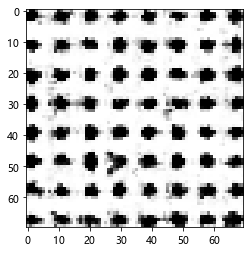

In [65]:
plt.imshow(confidence[0, 0], cmap='gray')

In [66]:
def nms(bbox, threshold):
    # 先按概率值进行排序
    bbox = sorted(bbox, key=lambda x:x.score, reverse=True)
    is_del = [False] * len(bbox)  # 从逻辑上表示bbox的数据点是否被删除
    out_put = []
    for i in range(len(bbox)):
        if is_del[i]:  # 如果为True，说明被删除了，则直接跳过
            continue
        for j in range(i, len(bbox)):  # 挨个遍历后面的所有数据点，计算交并比
            if is_del[j]:
                continue
            iou = bbox[i] ^ bbox[j]  # 计算交并比
            if iou > threshold:  # 大于阈值，则删除
                is_del[j] = True
        out_put.append(bbox[i])
    return out_put

# 找建议框共三步：
- 1、先根据confidence计算两个顶点的坐标
- 2、根据reg去修正坐标
- 3、使用nms进行抑制

Before NMS: 1073
After NMS:281


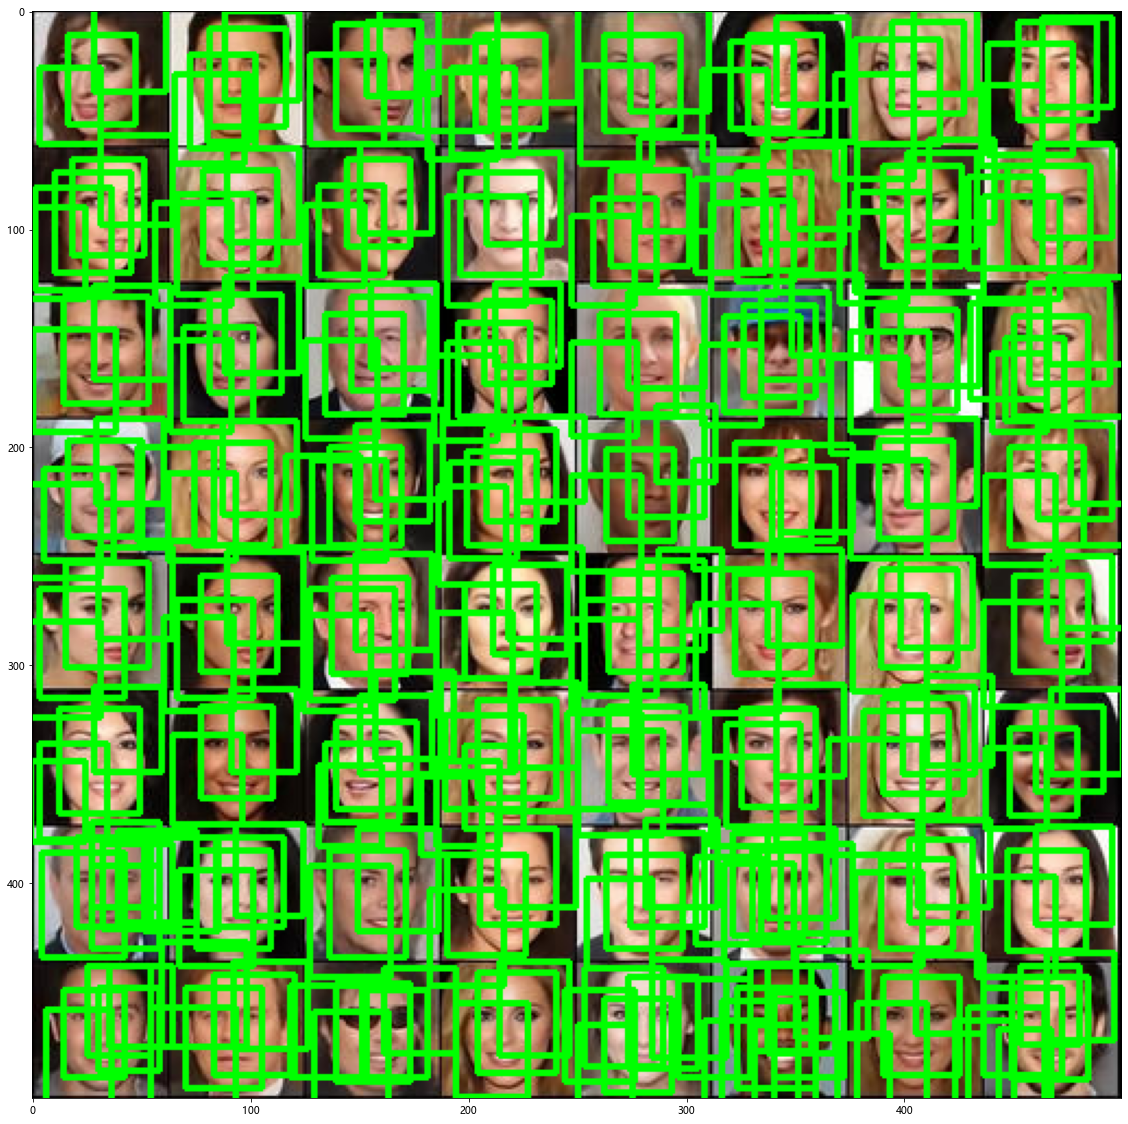

In [70]:
# confidence[0, 1]是正例的概率
raw_image = cv2.imread('../deep_img/face.jpg')
ys, xs = np.where(confidence[0, 1] > 0.5)  # 返回的是y轴坐标，x轴坐标
stride = 2
cell_size = 12  # 每隔12个像素切一张图

show = raw_image.copy()
bbox = []

# 选出建议框
for y, x in zip(ys, xs):
    score = confidence[0, 1, y, x]
    # 先计算滑窗的位置
    # x * stride + 1 是从最后输出的feature_map映射到pooling前的图的坐标
    # (x * stride + 1) / scale是从输入PNet的坐标映射到原图的坐标
    bx = (x * stride + 1) / scale
    by = (y * stride + 1) / scale
    br = (x * stride + cell_size) / scale
    bb = (y * stride + cell_size) / scale

    # 对结果进行修正，先死记
    reg_x = reg[0, 0, y, x]
    reg_y = reg[0, 1, y, x]
    reg_r = reg[0, 2, y, x]
    reg_b = reg[0, 3, y, x]

    dw = br - bx + 1
    dh = bb - by + 1

    bx = bx + reg_x * dw
    by = by + reg_y * dh
    br = br + reg_r * dw
    bb = bb + reg_b * dh

    bbox.append(BBox(bx, by, br, bb, score))

print(f'Before NMS: {len(bbox)}')
output = nms(bbox, 0.5)  # iou大于0.5的将会被抑制
print(f'After NMS: {len(output)}')
for obj in output:  # 标识人脸
    bx, by, br, bb = obj.locations()
    bx, by, br, bb = np.round([bx, by, br, bb]).astype(np.int64)
    cv2.rectangle(show, (bx, by), (br, bb), (0, 255, 0), 2)

plt.figure(figsize=(20, 20))
plt.imshow(show[..., ::-1])

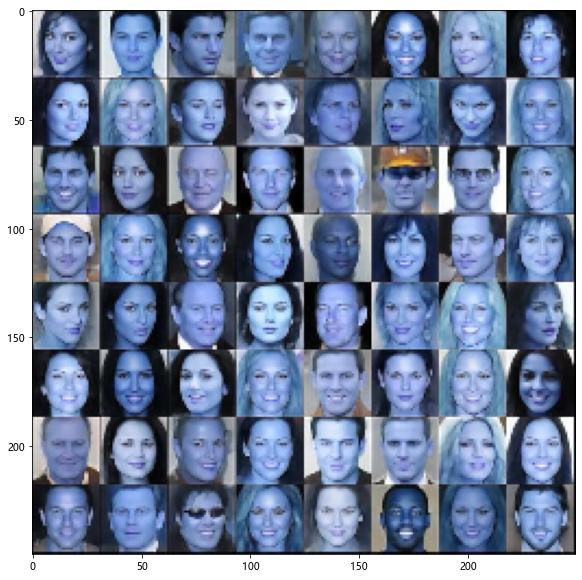

In [68]:
image = cv2.imread('../deep_img/face.jpg')
image = image.transpose(2, 0, 1)[None]
pooling = MaxPooling2d()
output = pooling(image)
output = output[0].transpose(1, 2, 0) / 255
plt.figure(figsize=(10, 10))
plt.imshow(output)

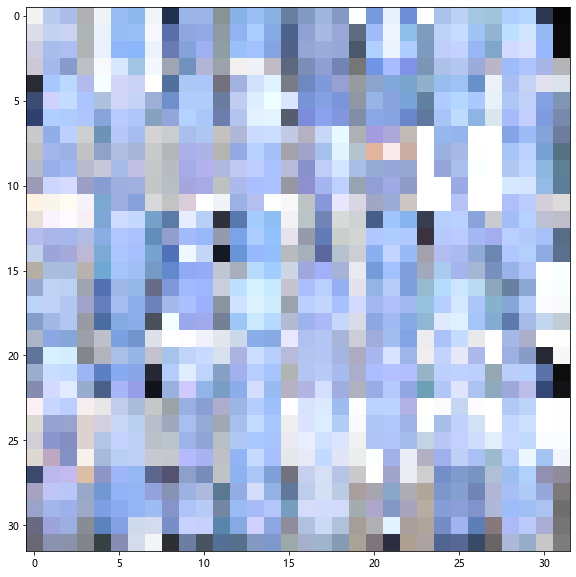

In [69]:
image = cv2.imread('../deep_img/face.jpg')
image = image.transpose(2, 0, 1)[None]
pooling = MaxPooling2d()
output = pooling(image)
output = pooling(output)
output = pooling(output)
output = pooling(output)
output = output[0].transpose(1, 2, 0) / 255
plt.figure(figsize=(10, 10))
plt.imshow(output)